# Standardzation

* python이 처음이라면 [Python Basic](https://colab.research.google.com/drive/1PCOoDIKypPVX9KTItMOht1cl96cPmeR_?authuser=1#scrollTo=3g6o04iLM0AF), [Python packages](https://colab.research.google.com/drive/1-1wx2VPEyNe11bmgpSpwdQgrJASCAqdH?authuser=1)를 먼저 학습하기를 권한다.

* package를 쉽게 설치하기 위해 Anaconda 사용을 권장한다.

경기과학고등학교 관측천문학 강좌를 위해 만들었으며  <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">크리에이티브 커먼즈 저작자표시-비영리-동일조건변경허락 4.0 국제 라이선스</a>에 따라 이용할 수 있음.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="크리에이티브 커먼즈 라이선스" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>


# Ground Based Observation


지상에서 관측하는 경우에 대기권에 의한 영향을 고려해야 한다. 중요한 두가지 문제는 

* Seeing
* Extinction (= scattering + absorption)

이다. 

instrumental magnitude (기기 등급)을 구한 후에 실제 등급을 구하는 과정을 우리는 standardization process (표준화 과정) 이라고 한다.


## 1. Seeing


Seeing 중요한 문제 중의 하나이다. 그 의미를 파악해 보자. 

대기의 상태가 변하기 때문에 point source 인 별빛이 부드럽게 퍼지게 되는데, 이를 **point spread function** (점퍼짐 함수)로 나타낼 수 있고, 줄여서 **psf** 라고도 한다.

널리 알려진 점퍼짐 함수로 **psf** [Gaussian](https://en.wikipedia.org/wiki/Gaussian_function) 과 [Moffat](https://en.wikipedia.org/wiki/Moffat_distribution)이 있다. 

psfs의 매개 변수 중 천문학에서 널리 사용되는 것은 FWHM (full width at half-maximum) 이다. FWHM은 $ \frac {1} {2} f_{\rm max} $ 값을 갖는 두 점 사이의 거리로 정의되며, 두 psf와 FWHM 에 대해 알아보자.


### 1.1. Gauss

원형으로 대칭인 Gauss psf는 다음과 같다.

$ f_{\rm Gauss}(r) = A e^{ -(r-r_0)^2/2\sigma^2 } $

여기에서 $r$ 은 원의 중심인 $r_0$ 로부터의 거리이고,  $\sigma$는 표준편차이다. 

normalization constant $A$는 $A = \frac{1}{\sqrt{2 \pi \sigma^2}}$ 이고, 

적분하면 $ \int_{-\infty}^{+\infty} f_{\rm Gauss}(r) dr = 1$ 이다. 

FWHM을 구하기 위하여 $f_{\rm Gauss}(r_{1/2}) = \frac{A}{2}$ 를 구하면 $ (r_{1/2} - r_0)^2 = 2 \sigma^2 \log_e 2 $ 이므로 

$ {\rm FWHM} := 2(r_{1/2} - r_0) = 2 \sigma \sqrt{2 \log_e 2}  ~$ 이다.



### 1.2. Moffat

원형으로 대칭인 Moffat psf는 다음과 같다. 

$f_{\rm Moffat} (r) = A \left [ 1 + \left ( \frac{r-r_0}{R} \right )^2 \right ]^{-\beta} ~.$

여기에서 Gauss psf에서와 마찬가지로 $r$은 원의 중심인 $r_0$ 로 부터의 거리이다. 

normalization constant $A$ 는 $ A = \frac{\Gamma(\beta)}{R\sqrt{\pi} \Gamma(\beta-\frac{1}{2})} $ 이고, parameter $R$ 은 core width라 부르고, $\beta$는 power라고 한다. 

[astropy Moffat 2D](http://docs.astropy.org/en/stable/api/astropy.modeling.functional_models.Moffat2D.html#astropy.modeling.functional_models.Moffat2D)에서 `gamma`는 core width ($R$)과 `alpha`가 power ($\beta$)로 사용됨에 유의하자.

Gauss pdf에서 했던 바와 같이 FWHM을 $f_{\rm Moffat}(r_{1/2}) = \frac{A}{2}$ 를 구하면 

$ (r_{1/2} - r_0)^2 = R^2 (2^{1/\beta}-1) $

따라서, 

$ {\rm FWHM} := 2(r_{1/2} - r_0) = 2 R \sqrt{2^{1/\beta}-1} ~$ 이다. 

Moffat에 대해 더 궁금한 점은 [paper](http://adsabs.harvard.edu/cgi-bin/bib_query?bibcode=1969A%26A.....3..455M&db_key=AST) (Astronomy and Astrophysics, Vol. 3, p. 455 (1969)) 를 참고하자.


### 1.3. Comparison (Gauss VS Moffat)

균일한 대기 조건에서 노출시간을 길게 할 경우 psf는 대칭 모양으로 수렴되어 등치곡선이 동심원처럼 보여야 하지만 실제는 이와 다를 수 있다. 

어떤 경우에는 타원형으로 나타나고, 심지어 불규칙한 모양의 등치곡선이 나타날 수 도 있다. 

다음 예제에서는 1차원 단순 사례에서 Gaussian과 Moffat의 차이점을 보기 위해 Astropy를 사용하여 simulate 해 본 것이다. 

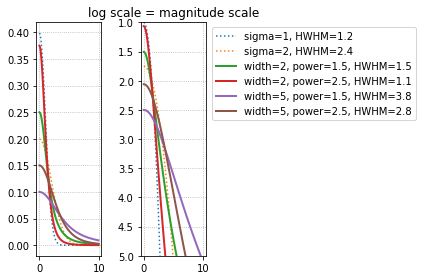

In [6]:
from astropy.modeling.functional_models import Moffat1D, Gaussian1D
from scipy.special import gamma as G
import numpy as np
from matplotlib import pyplot as plt

def norm_gauss(sigma):
    return 1/np.sqrt(2 * np.pi * sigma**2)

def norm_moffat(width, power):
    return G(power) / (width * np.sqrt(np.pi) * G(power - 1/2))

def HWHM_moffat(width, power):
    return width * np.sqrt( 2**(1/power) - 1)

x       = np.arange(0,10,0.1)
sigma   = np.array([1, 2])
width   = np.array([2, 5])
power   = np.array([1.5, 2.5])

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
for s in sigma:
    gauss  = Gaussian1D(amplitude=1, mean=0, stddev=s)    
    ax1.plot(x, norm_gauss(s)*gauss(x), ls=":", 
             label="sigma={0:.0f}, HWHM={1:.1f}".format(s, 2.355*s/2))
    ax2.plot(x, -2.5 * np.log10(norm_gauss(s)*gauss(x)), ls=":", 
             label="sigma={0:.0f}, HWHM={1:.1f}".format(s, 2.355*s/2))

for w in width:
    for p in power:
        moffat = Moffat1D(amplitude=1, x_0=0, gamma=w, alpha=p)
        HWHM   = HWHM_moffat(w, p)
        ax1.plot(x, norm_moffat(w, p) * moffat(x), lw=2,
                 label='w={0:.0f}, p={1:.1f}, HWHM={2:.1f}'.format(w, p, HWHM))
        ax2.plot(x, -2.5*np.log10(norm_moffat(w, p) * moffat(x)), lw=2,
                 label='width={0:.0f}, power={1:.1f}, HWHM={2:.1f}'.format(w, p, HWHM))

ax1.grid(ls=":")
ax2.grid(ls=":")
ax2.set_ylim(1, 5)
ax2.invert_yaxis()
ax2.set_title('log scale = magnitude scale')
plt.legend(bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

Moffat은 그의 1969 년 논문에서 다음과 같이 기술하고 있다. 

> Two-dimensional intensity profiles of focal stellar images in photographic emulsions were derived by convolving gaussian seeing distributions with diffraction proffles and emulsion scattering functions. **The results predict too low an intensity for large radial distances from the centre of the image**, contradicting the assumption that seeing is gaussian.

위 그림에서 파란색 점선 (Gauss, FWHM 1.2)과 빨간색 실선 (Moffat, FWHM 1.1)을 비교 해 보면 함수의 종류 보다는 FWHM이 더 관련이 높음을 알 수 있다. 

psf normalize 하여 simulate 해 보면 별의 전체 플럭스는 일정하지만, psf는 가 대기 조건(seeing)에 따라 달라지는 것을 볼 수 있다. 

## 2. Extinction

대기의 **absorption** 와 **scattering** 때문에 flux는 감소하게 된다. instrument와 같은 노출시간으로 촬영하더라도 날씨의 영향으로 flux는 다르게 측정될 수 있다. 

더 복잡한 문제는 extinction이 파장의 함수이므로 다른 필터에 대해 다른 extinction factor를 적용해야 하는 것이다. 


### 2.1. Atmospheric Extinction

평평하고 균질한 대기를 가정할 때 flux는 $e^{-\tau}$의 factor에 의해 감소하는데, $\tau$ 는 광학적 두께이다. 

logarithmic scale 등급계에서 등급의 증가가 공기의 질량에 비례함을 의미한다.

$X = \sec(z)$일 때, $ m(X) = m_0 + k_X X $

여기에서 $m$ 은 관측된 등급, $m_0$ 은 대기가 없을 때의 등급이며, $k_X$ 는 *extinction coefficient* 라 부르는 상수이다. 


### 2.2. Wavelength Dependence

absorption와 scattering을 포함한 소광은 파장에 의존한다. 

[Rayleigh scattering](https://en.wikipedia.org/wiki/Rayleigh_scattering) 즉, 입자의 크기를 나타내는 size parameter $x$ 보다 파장이 훨씬 길면 ($x \ll \lambda$) 소광은 $\lambda^{-4}$에 비례한다.

그래서 더 짧은 파장은 더 큰 $k_X$ 값을 가져야 하고, atmospheric extinction 이 더 많음을 의미한다.

> $k_X$ 는 파장에 의존적으로 ($k_{X, \lambda}$) 전형적으로 다음 값을 사용한다.
 * 0.4 in U-band
 * 0.2 in B-band
 * 0.1 in V-band

광대역 관측에서 "wavelength" 이라는 단어는 "filter"로 대체 될 수 있으며, V 밴드의 크기를 원하면 계수 $ a $와 $ k_ {XC} $를

$ m_V = m_{V, 0} + k_{X, V} X + a({\rm B}-{\rm V}) + k_{XC, V} X ({\rm B}-{\rm V}) ~$

로 부터 찾아야 한다.

B 대신 U, R, I 등의 다른 밴드를 사용할 수 있지만 B가 일반적이고, $ k_ {XC} $의 첨자 C는 color 를 "의미한다. 

다행히도 $ a $는 매우 작고 ($ | a | \lesssim 0.1 $), 대부분의 경우 $ k _ {\ rm XC} $는 거의 0 이므로, B-V color 값이 일반적으로 1보다 작다는 것을 고려하면 color term 은 매우 무시할 수 있음을 알 수 있다. 

특히 $ k_ {XC} $의 도입은 많은 경우 불확실성을 증가 시키므로 하늘이 아주 명확하지 않으면 일반적으로 사용되지 않다.

> 색상 의존 조건 ($k_{XC, V}$ 와 $a$) 은 매우 정확한 결정이 필요한 경우가 아니면 별로 유용하지 않다.


## 3. Zero-point

우리가 프로그램이나 소프트웨어로부터 계산할 수있는 것은 $ m_{\rm inst} = 2.5 \log_{10} ( \rm ADU~ sec^{-1})$ 로 이를 **instrumental magnitude** 라고 한다. 이 등급은 기기의 특성에 의해 나타나는 것으로 실제와는 매우 다르다. 

$ \rm ADU $ 에 대한 normalization 은 0-mag 의 별을 사용하여 수학적으로 Pogson's fomula를 사용하여 수행 할 수 있다.

**zeropoint** magnitude를 $ m_z $로 표시한다면 실제 크기는 $ \Delta m = m_{\rm inst} - m_z $ 가 된다.


## 4. Standardization

### 4.1. Idea

zeropoint correction과 extinction correction을 수행하고, color terms를 무시하면 우리는 

$m_{0, V} = m_{{\rm inst}, V} - m_{z, V} - k_{X, V} X \quad( - {\rm color~correction~terms})~$ 

좀 더 친숙하게 $m_{0, V} $ 를 $ V $, $m_{{\rm inst}, V}$ 를 $v$ 등으로 바꾸면, 

$ v - V = z_{V} + k_{V} X \quad( + {\rm color~correction~terms})~ $

예를 들어, V-band에 대해서 일반적으로 사람들은 실제 등급을 소문자로 사용하고, 기기 등급을 대문자로 사용하며 *기기 등급을 실제 등급으로 변환하는 과정*을 **standardization** 이라고 한다.


### 4.2. Standardization in Practice

우리가 알고있는 것은 단지 $ X $이고 우리가 계산할 수있는 것은 $ m_ {\rm inst} $인데, 어떻게 $ m_z $와 $ k_X $를 구할 수 있을까?

**standard stars**를 이용하면 된다. 유명한 것이 **Landolt standard stars** 이다.

거의 동일한 sky condition 에서 standard stars 표준 별의 이미지를 찍습니다. 그리고 $ m_{\ rm inst} - m_0 $ VS $ X $로 그래프를 그리면 기울기와 절편은 각각 $ k_X $와 $ m_z $ 이다. 이러한 가정은 extinction이 wavelength (or color)에 의존하는 것을 무시하고, 하늘 상태에 따라 달라지기 때문에 **원칙적으로 매일 밤** 수행해야 한다. 

가장 쉬운 경우는 측정 천체가 거의 동일한 천정 거리 (즉, 상수 $ X $) 인 경우이며, 이런 경우에는  $ k_X X $를 상수로 간주하고 $ m_z $의 일부로 설정하면 $ m_0 = m _ {\rm inst} - m_z '$가 된다. 


## Example 1: Calculating Instrumental Magnitude and Color

두 개의 천체와 세개의 standard star 자료로 연습해 보자. 

각각의 standard star를 관측할 때 대기의 $X$ 값은 1.0, 1.3, 2.0 이라고 하고, V-band 와 B-band 의 exposure time은 'T_B'와 'T_V'이다.

photon counts는`count_V`와`count_B`이고, gain value 는 'gain = 1.0'이라고 하고 read out noise 는 무시하자. 또한 하늘 상태는 매우 좋았다고 가정하자. 

> **How can we calculate the magnitudes, colors, and their uncertainties?** 

instrumental magnitude 는 'b'와 'v', real magnitude'B', 'V'로 표현할 것이다. 

먼저 데이터를 load 하여 print 해 보자. 

In [2]:
from astropy.io.ascii import read
data = read('Standardization_data_0.dat')
print(type(data))
data.pprint

<class 'astropy.table.table.Table'>


<bound method Table.pprint of <Table length=11>
Target    X     T_V   T_B  count_V  count_B 
 str4  float64 int32 int32  int32    int32  
------ ------- ----- ----- -------- --------
  obj1     1.2    15    30  8695591 14211249
  obj2     1.4   200   400   180181   112201
  std1     1.0     5    10 12687301 22438244
  std2     1.0     5    10  5534312  7521077
  std3     1.0     5    10  2280320  1835230
  std1     1.3     7    12 14711983 25343232
  std2     1.3     7    12  6404748  8489650
  std3     1.3     7    12  2638025  2060068
  std1     2.0     9    15 15845201 25669738
  std2     2.0     9    15  6885820  8636456
  std3     2.0     9    15  2796503  2042511>

astropy 테이블에 대한 자세한 내용은 [this manual page](http://docs.astropy.org/en/stable/table/) 를 읽어보기 바란다.

instrumental magnitude 는 

$ m_{\rm inst} \equiv -2.5 \log_{10}\left ( \frac{N}{\Delta t} \right ) ~$

로 구할 수 있다.

instrumental magnitude은 $m_{\rm inst}$ `b`, `v`로 나타내고, 

$N$ ("count")는 `count_V`, `count_B` column에 있으며, $\Delta t$는 exposure time in seconds로 `T_V`, `T_B`에 있다. 

이 계산을 위해 `numpy.ndarray`와 비슷한 `Astropy.Table`을 사용하였다. 

In [3]:
import numpy as np
from astropy.io.ascii import read
from astropy import table

# b, v, c means instrumental B, V magnitudes and instrumental B-V color.
v  = table.Column(name='v' , data = -2.5 * np.log10(data['count_V']/data['T_V']))
b  = table.Column(name='b' , data = -2.5 * np.log10(data['count_B']/data['T_B']))

c  = table.Column(name='color' , data = b-v)

# Only save upto 3 or 5 decimal points
v.format  ='%6.3f'
b.format  ='%6.3f'
c.format  ='%6.3f'

data.add_columns([v, b, c])

# To be more visual, I will "sort" with respect to the column 'Target':
data = data.group_by('Target') 

# Then print:
data.pprint(max_width=200)  # max_width is used to print out all the values

Target  X  T_V T_B count_V  count_B     v       b    color 
------ --- --- --- -------- -------- ------- ------- ------
  obj1 1.2  15  30  8695591 14211249 -14.408 -14.189  0.219
  obj2 1.4 200 400   180181   112201  -7.387  -6.120  1.267
  std1 1.0   5  10 12687301 22438244 -16.011 -15.877  0.134
  std1 1.3   7  12 14711983 25343232 -15.806 -15.812 -0.005
  std1 2.0   9  15 15845201 25669738 -15.614 -15.583  0.031
  std2 1.0   5  10  5534312  7521077 -15.110 -14.691  0.420
  std2 1.3   7  12  6404748  8489650 -14.904 -14.624  0.279
  std2 2.0   9  15  6885820  8636456 -14.709 -14.401  0.309
  std3 1.0   5  10  2280320  1835230 -14.148 -13.159  0.988
  std3 1.3   7  12  2638025  2060068 -13.940 -13.087  0.854
  std3 2.0   9  15  2796503  2042511 -13.731 -12.835  0.896


-----

## Example 2: Merge Literature Data

standard stars는 B와 V의 magnitudes 와 color index가 정확하다고 가정하자. 

> ** instrumental magnitudes와 literature magnitude를 비교해 보자.

literature value를 읽어보자.

In [4]:
import numpy as np
from astropy.io.ascii import read
std = read('Standardization_data_std.dat')
std.pprint
#print (std)

<bound method Table.pprint of <Table length=3>
Target    V     COLOR     B   
 str4  float64 float64 float64
------ ------- ------- -------
  std1     9.1    -0.3     8.8
  std2    10.0     0.0    10.0
  std3    11.0     0.6    11.6>

standardization을 하기 위해 standard stars literature value를 join 하자.

Target  X  T_V T_B count_V  count_B     v       b    color   V   COLOR  B  
------ --- --- --- -------- -------- ------- ------- ------ ---- ----- ----
  std1 1.0   5  10 12687301 22438244 -16.011 -15.877  0.134  9.1  -0.3  8.8
  std1 1.3   7  12 14711983 25343232 -15.806 -15.812 -0.005  9.1  -0.3  8.8
  std1 2.0   9  15 15845201 25669738 -15.614 -15.583  0.031  9.1  -0.3  8.8
  std2 1.0   5  10  5534312  7521077 -15.110 -14.691  0.420 10.0   0.0 10.0
  std2 1.3   7  12  6404748  8489650 -14.904 -14.624  0.279 10.0   0.0 10.0
  std2 2.0   9  15  6885820  8636456 -14.709 -14.401  0.309 10.0   0.0 10.0
  std3 1.0   5  10  2280320  1835230 -14.148 -13.159  0.988 11.0   0.6 11.6
  std3 1.3   7  12  2638025  2060068 -13.940 -13.087  0.854 11.0   0.6 11.6
  std3 2.0   9  15  2796503  2042511 -13.731 -12.835  0.896 11.0   0.6 11.6
Plot of literature VS instrumental magnitudes


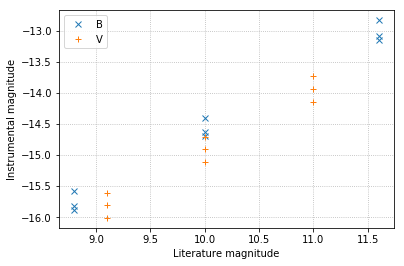

In [5]:
data_std = table.join(data, std, keys='Target')
# Joins two tables, data and std, based on the column 'Target'.
# Columns with name 'obj1' and 'obj2' does not exist in table std,
# so those rows will be deleted.
data_std.pprint(max_width=200)

print('Plot of literature VS instrumental magnitudes')
from matplotlib import pyplot as plt
plt.plot(data_std['B'], data_std['b'], marker='x', mfc='b', ls='', label='B')
plt.plot(data_std['V'], data_std['v'], marker='+', mfc='r', ls='', label='V')
plt.xlabel('Literature magnitude')
plt.ylabel('Instrumental magnitude')
plt.grid(ls=':')
plt.legend()
plt.show()

결과를 보면 literature magnitude와 instrumental magnitude 는 약 25 정도 차이가 나는데, linear relationship이 매우 좋다. instrumental magnitude를 literature magnitude 와 일치키시는 과정이 바로 standardization 이다.